In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import xarray as xr
from plotly.subplots import make_subplots
from scipy.stats import t
import plotly.express as px

In [2]:
station = "Bats"
time_start = "2002-01-01"
time_end = "2015-01-01"

## Load


In [3]:
data = xr.load_dataset(f"../data/1_products/{station}_obs_filtered.zarr", engine="zarr")
data

<xarray.Dataset> Size: 13kB
Dimensions:    (time: 529, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * time       (time) datetime64[ns] 4kB 1995-05-10 1995-05-11 ... 2022-12-13
Data variables:
    day        (time, latitude, longitude, layer) float64 4kB nan ... 0.362
    night      (time, latitude, longitude, layer) float64 4kB 1.108 nan ... 1.11
Attributes:
    creation date:  2024-10-13T20:03:40.209673
    layer:          epipelagic
    station:        Bats

## Computing the trend


In [4]:
def plot_trend(day_data, night_data, poly_order=1, confidence_level=0.95):
    # day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
    time_indices = (day_data["time"] - day_data["time"][0]).astype(int)  # .astype("timedelta64[D]").astype(int)
    day_trend = np.polyfit(time_indices, day_data, poly_order)
    day_trend_line = np.polyval(day_trend, time_indices)
    day_std_error = np.std(day_data - day_trend_line) / np.sqrt(len(day_data))
    degrees_freedom_day = len(day_data) - 2
    t_critical_day = t.ppf((1 + confidence_level) / 2, degrees_freedom_day)
    day_confidence_interval = float(t_critical_day * day_std_error)

    # night_data = data["night"][:, 0, 0, 0].dropna(dim="time")
    night_time_indices = (night_data["time"] - night_data["time"][0]).astype(
        int
    )  # .astype("timedelta64[D]").astype(int)
    night_trend = np.polyfit(night_time_indices, night_data, poly_order)
    night_trend_line = np.polyval(night_trend, night_time_indices)
    night_std_error = np.std(night_data - night_trend_line) / np.sqrt(len(night_data))
    degrees_freedom_night = len(night_data) - 2
    t_critical_night = t.ppf((1 + confidence_level) / 2, degrees_freedom_night)
    night_confidence_interval = float(t_critical_night * night_std_error)

    figure = go.Figure()

    figure.add_trace(
        go.Scatter(
            x=day_data.indexes["time"],
            y=day_data,
            mode="markers",
            name="Day Data",
            marker={"color": "firebrick"},
        )
    )
    figure.add_trace(
        go.Scatter(
            x=day_data.indexes["time"],
            y=day_trend_line,
            mode="lines",
            name="Day Trend Line",
            line={"color": "firebrick"},
        )
    )
    figure.add_trace(
        go.Scatter(
            x=list(day_data.indexes["time"]) + list(day_data.indexes["time"])[::-1],
            y=list(day_trend_line + day_confidence_interval) + list(day_trend_line - day_confidence_interval)[::-1],
            fill="toself",
            fillcolor="rgba(255, 0, 0, 0.2)",
            line_color="rgba(0, 0, 0, 0)",
            name="Day Confidence Interval",
        )
    )
    figure.add_trace(
        go.Scatter(
            x=night_data.indexes["time"],
            y=night_data,
            mode="markers",
            name="Day Data",
            marker={"color": "royalblue"},
        )
    )
    figure.add_trace(
        go.Scatter(
            x=night_data.indexes["time"],
            y=night_trend_line,
            mode="lines",
            name="Night Trend Line",
            line={"color": "royalblue"},
        )
    )

    figure.add_trace(
        go.Scatter(
            x=list(night_data.indexes["time"]) + list(night_data.indexes["time"])[::-1],
            y=list(night_trend_line + night_confidence_interval)
            + list(night_trend_line - night_confidence_interval)[::-1],
            fill="toself",
            fillcolor="rgba(0, 0, 255, 0.2)",
            line_color="rgba(0, 0, 0, 0)",
            name="Night Confidence Interval",
        ),
    )

    figure.update_layout(height=600)
    return figure

In [5]:
confidence_level = 0.95
day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
night_data = data["night"][:, 0, 0, 0].dropna(dim="time")

plot_trend(day_data, night_data, poly_order=1).update_layout(
    title=f"{station} Day and Night Trend (1st order polynomial fit)",
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m3)",
).show()

In [6]:
confidence_level = 0.95
day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
night_data = data["night"][:, 0, 0, 0].dropna(dim="time")

plot_trend(day_data, night_data, poly_order=2).update_layout(
    title=f"{station} Day and Night Trend (2nd order polynomial fit)",
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m3)",
).show()

In [7]:
fig = go.Figure()

# Plot day data
fig.add_trace(
    go.Scatter(
        x=data.day.dropna("time").time.data.flatten(),
        y=data.day.dropna("time").data.flatten(),
        mode="lines",
        name="Day",
    )
)

# Plot night data
fig.add_trace(
    go.Scatter(
        x=data.night.dropna("time").time.data.flatten(),
        y=data.night.dropna("time").data.flatten(),
        mode="lines",
        name="Night",
    )
)

# Add vertical lines for 2000 and 2015
fig.add_shape(
    type="line",
    x0=time_start,
    y0=0,
    x1=time_start,
    y1=1,
    xref="x",
    yref="paper",
    line=dict(color="black", width=2, dash="dash"),
    name="Year 2000",
)

fig.add_shape(
    type="line",
    x0=time_end,
    y0=0,
    x1=time_end,
    y1=1,
    xref="x",
    yref="paper",
    line=dict(color="black", width=2, dash="dash"),
    name="Year 2015",
)

# Update layout
fig.update_layout(
    title=f"Day and Night Data at {station} : remove interannual variability",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
    legend_title="Legend",
    height=600,
    # width=800,
    showlegend=True,
)

fig.show()

In [8]:
data = data.sel(time=slice(time_start, time_end))

In [9]:
confidence_level = 0.95
day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
night_data = data["night"][:, 0, 0, 0].dropna(dim="time")

plot_trend(day_data, night_data, poly_order=2).show()

## Number of samples


In [72]:
counts_month = (
    data.groupby("time.month")
    .count()
    .isel(latitude=0, longitude=0, layer=0)
    .drop_vars(["latitude", "longitude", "layer"])
    .to_dataframe()
)
counts_year = (
    data.groupby("time.year")
    .count()
    .isel(latitude=0, longitude=0, layer=0)
    .drop_vars(["latitude", "longitude", "layer"])
    .to_dataframe()
)

In [81]:
px.bar(
    counts_month,
    x=counts_month.index,
    y=counts_month.columns,
    # side by side
    barmode="group",
    title=f"Counts of {station} data per month",
    labels={"value": "Counts"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
).update_layout(xaxis_title="Month", height=600).show()

In [76]:
px.bar(
    counts_year,
    x=counts_year.index,
    y=counts_year.columns,
    # side by side
    barmode="group",
    title=f"Counts of {station} data per year",
    labels={"value": "Counts"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
).update_layout(xaxis_title="Year", height=600).show()

## Group data by week


In [83]:
grouped_data = xr.Dataset({"day": data.day, "night": data.night})

# Calculer les moyennes mensuelles des données détrendées
grouped_data = grouped_data.groupby("time.week").mean()

# ajouter des nan pour les semaines manquantes
grouped_data = grouped_data.reindex(week=np.arange(1, 53))
grouped_data

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/dataset.py:227: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.



<xarray.Dataset> Size: 1kB
Dimensions:    (latitude: 1, layer: 1, longitude: 1, week: 52)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * week       (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    day        (week, latitude, longitude, layer) float64 416B nan nan ... nan
    night      (week, latitude, longitude, layer) float64 416B nan nan ... nan

## Raw data, no smoothing


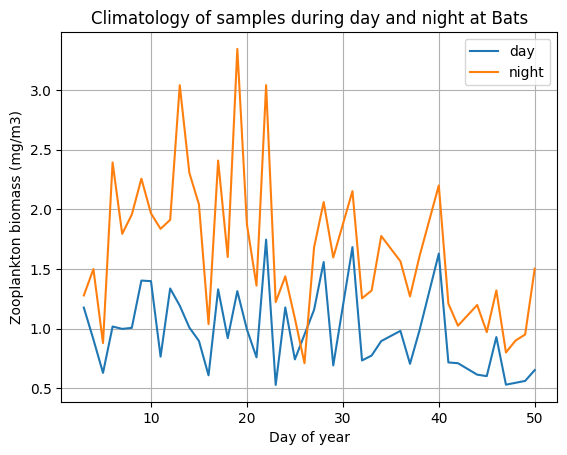

In [84]:
grouped_data.day.dropna("week").plot(label="day")
grouped_data.night.dropna("week").plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Smooth


In [85]:
window_size = 3
pad_size = window_size + 2

# Étendre les données pour simuler la cyclicité
extended_ds = grouped_data.pad(week=(pad_size, pad_size), mode="wrap")

# Appliquer la fenêtre mobile
smoothed = (
    extended_ds.rolling(week=window_size, center=True, min_periods=1)
    .mean()
    .isel(week=slice(pad_size, -pad_size))  # Revenir à la taille originale
)
smoothed

<xarray.Dataset> Size: 1kB
Dimensions:    (latitude: 1, layer: 1, longitude: 1, week: 52)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * week       (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    day        (week, latitude, longitude, layer) float64 416B nan 1.176 ... nan
    night      (week, latitude, longitude, layer) float64 416B nan 1.278 ... nan

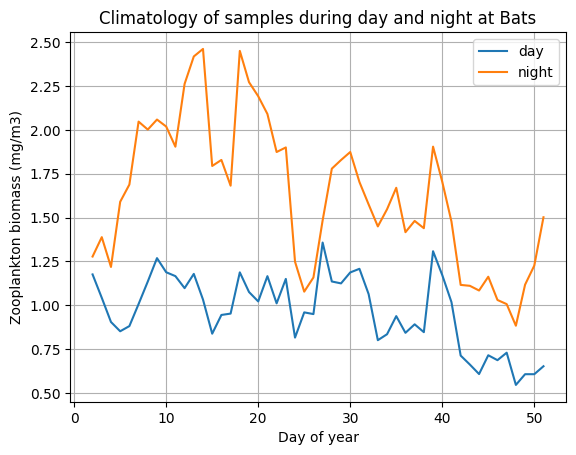

In [86]:
smoothed.day.plot(label="day")
smoothed.night.plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Duplicating observation across the entire time period


In [ ]:
value_by_week = smoothed.to_dataframe().reset_index().drop(columns=["latitude", "longitude", "layer"]).set_index("week")
value_by_week.head()

In [ ]:
week_by_day = (
    pd.date_range(start=data.indexes["time"][0], end=data.indexes["time"][-1], freq="W")
    .isocalendar()
    .drop(columns=["day", "year"])
)
week_by_day.head()

In [ ]:
aggregated_smoothed = week_by_day.join(value_by_week, on="week").drop(columns=["week"])
aggregated_smoothed.index.name = "time"
aggregated_smoothed

In [ ]:
# # Créer une série temporelle pour les tendances de jour et de nuit
# day_trend_series = pd.Series(day_trend_line - day_trend_line[0], index=day_data["time"].values)
# night_trend_series = pd.Series(night_trend_line - night_trend_line[0], index=night_data["time"].values)

# # Réindexer les séries temporelles pour correspondre à l'index de aggregated_smoothed_detrended
# day_trend_interpolated = day_trend_series.reindex(aggregated_smoothed_detrended.index, method="nearest")
# night_trend_interpolated = night_trend_series.reindex(aggregated_smoothed_detrended.index, method="nearest")

# # Ajouter les tendances interpolées au DataFrame aggregated_smoothed_detrended
# aggregated_smoothed_detrended["day_trend"] = day_trend_interpolated
# aggregated_smoothed_detrended["night_trend"] = night_trend_interpolated

# aggregated_smoothed_detrended.index.name = "time"

# # Afficher le DataFrame avec les tendances ajoutées
# aggregated_smoothed_detrended.head()

In [ ]:
climato_observations = xr.Dataset.from_dataframe(aggregated_smoothed)
climato_observations

## Plot final results


In [ ]:
fig = make_subplots(rows=1, cols=1)

# Ajouter les données de jour et de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["day"],  #  + aggregated_smoothed["night_trend"]
        mode="lines",
        name="Day Data with Trend",
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["night"],  # + aggregated_smoothed["night_trend"],
        mode="lines",
        name="Night Data with Trend",
    ),
    row=1,
    col=1,
)

# # Ajouter les tendances de jour et de nuit
# fig.add_trace(
#     go.Scatter(
#         x=aggregated_smoothed.index,
#         y=aggregated_smoothed["day_trend"],
#         mode="lines",
#         name="Day Trend",
#         line=dict(dash="dash"),
#     ),
#     row=1,
#     col=1,
# )
# fig.add_trace(
#     go.Scatter(
#         x=aggregated_smoothed.index,
#         y=aggregated_smoothed["night_trend"],
#         mode="lines",
#         name="Night Trend",
#         line=dict(dash="dash"),
#     ),
#     row=1,
#     col=1,
# )

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Evolution des données de jour et de nuit avec tendance à {station}",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
)

fig.show()

In [ ]:
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Day Data", "Night Data"),
    shared_xaxes=True,
    vertical_spacing=0.1,
)
# augmente la taille de la figure
fig.update_layout(height=800)

# Ajouter les données d'observation initiales de jour
fig.add_trace(
    go.Scatter(
        x=day_data["time"],
        y=day_data,
        mode="lines",
        name="Initial Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données obtenues après traitement de jour
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["day"],  # + aggregated_smoothed["day_trend"],
        mode="lines",
        name="Processed Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données d'observation initiales de nuit
fig.add_trace(
    go.Scatter(
        x=night_data["time"],
        y=night_data,
        mode="lines",
        name="Initial Night Data",
    ),
    row=2,
    col=1,
)

# Ajouter les données obtenues après traitement de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["night"],  # + aggregated_smoothed["night_trend"],
        mode="lines",
        name="Processed Night Data",
    ),
    row=2,
    col=1,
)

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Comparison of Initial and Processed Data at {station} : With Trend",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
)

fig.show()

## Export


In [ ]:
climato_observations

In [ ]:
climato_observations = climato_observations.expand_dims(
    latitude=[data.latitude[0]], longitude=[data.longitude[0]], layer=[data.layer[0]]
)
climato_observations = climato_observations.transpose("time", "latitude", "longitude", "layer")

In [ ]:
climato_observations.latitude.attrs = data.latitude.attrs
climato_observations.longitude.attrs = data.longitude.attrs
climato_observations.layer.attrs = data.layer.attrs
climato_observations.time.attrs = data.time.attrs
climato_observations.day.attrs = data.day.attrs
climato_observations.night.attrs = data.night.attrs
# climato_observations.day_trend.attrs = {"units": "mg/m3", "long_name": "Day Trend"}
# climato_observations.night_trend.attrs = {"units": "mg/m3", "long_name": "Night Trend"}
climato_observations

In [ ]:
climato_observations.to_zarr(f"./products/{station}_climato.zarr", mode="w")